In [1]:
#refer to DeepPurpose: https://github.com/kexinhuang12345/DeepPurpose

import warnings
warnings.filterwarnings("ignore")
import json
import os 
print(os.path.abspath('.'))

#import wget
from zipfile import ZipFile 
#from DeepPurpose.utils import convert_y_unit

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import rdBase, Chem, DataStructs

In [ ]:
def convert_y_unit(y, from_, to_):
    # basis as nM

    if from_ == 'nM':
        y = y
    elif from_ == 'p':
        y = 10**(-y) / 1e-9

    if to_ == 'p':
        y = -np.log10(y*1e-9 + 1e-10)
    elif to_ == 'nM':
        y = y

    return y

In [ ]:
def process_BindingDB(path = None, df = None, y = 'Kd', binary = False, convert_to_log = True, threshold = 30):
    if not os.path.exists(path):
        os.makedirs(path)

    if df is not None:
        print('Loading Dataset from the pandas input...')
    else:
        print('Loading Dataset from path...')
        df = pd.read_csv(path, sep = '\t', error_bad_lines=False)
    print('Beginning Processing...')
    df = df[df['Number of Protein Chains in Target (>1 implies a multichain complex)'] == 1.0]
    df = df[df['Ligand SMILES'].notnull()]

    if y == 'Kd':
        idx_str = 'Kd (nM)'
    elif y == 'IC50':
        idx_str = 'IC50 (nM)'
    elif y == 'Ki':
        idx_str = 'Ki (nM)'
    elif y == 'EC50':
        idx_str = 'EC50 (nM)'
    else:
        print('select Kd, Ki, IC50 or EC50')

    df_want = df[df[idx_str].notnull()]
    df_want = df_want[['BindingDB Reactant_set_id', 'Ligand InChI', 'Ligand SMILES',\
                      'PubChem CID', 'UniProt (SwissProt) Primary ID of Target Chain',\
                      'BindingDB Target Chain  Sequence', idx_str]]
    df_want.rename(columns={'BindingDB Reactant_set_id':'ID',
                            'Ligand SMILES':'SMILES',
                            'Ligand InChI':'InChI',
                            'PubChem CID':'PubChem_ID',
                            'UniProt (SwissProt) Primary ID of Target Chain':'UniProt_ID',
                            'BindingDB Target Chain  Sequence': 'Target Sequence',
                            idx_str: 'Label'}, 
                            inplace=True)

    df_want['Label'] = df_want['Label'].str.replace('>', '')
    df_want['Label'] = df_want['Label'].str.replace('<', '')
    df_want['Label'] = df_want['Label'].astype(float)
    
    # have at least uniprot or pubchem ID
    df_want = df_want[df_want.PubChem_ID.notnull() | df_want.UniProt_ID.notnull()]
    df_want = df_want[df_want.InChI.notnull()]

    df_want = df_want[df_want.Label <= 10000000.0]
    print('There are ' + str(len(df_want)) + ' drug target pairs.')

    if binary:
        print('Default binary threshold for the binding affinity scores are 30, you can adjust it by using the "threshold" parameter')
        y = [1 if i else 0 for i in df_want.Label.values < threshold]
    else:
        if convert_to_log:
            print('Default set to logspace (nM -> p) for easier regression')
            y = convert_y_unit(df_want.Label.values, 'nM', 'p') 
        else:
            y = df_want.Label.values

    return df_want.SMILES.values, df_want['Target Sequence'].values, np.array(y)

In [ ]:
smiles, targets, y = process_BindingDB(path = 'BindingDB_All.tsv', df = None, y = 'Kd', binary = False, convert_to_log = True, threshold = 10)

In [ ]:
df = pd.DataFrame(zip(smiles, targets, y))
df.rename(columns={0:'SMILES',1: 'Target Sequence',2: 'Label'}, inplace=True)
print('in total: ' + str(len(df)) + ' drug-target pairs')

In [10]:
df.shape

(66444, 3)

In [11]:
df_include_tie2=df[df.Target Sequence.isin(['MDSLASLVLCGVSLLLSGTVEGAMDLILINSLPLVSDAETSLTCIASGWRPHEPITIGRDFEALMNQHQDPLEVTQDVTREWAKKVVWKREKASKINGAYFCEGRVRGEAIRIRTMKMRQQASFLPATLTMTVDKGDNVNISFKKVLIKEEDAVIYKNGSFIHSVPRHEVPDILEVHLPHAQPQDAGVYSARYIGGNLFTSAFTRLIVRRCEAQKWGPECNHLCTACMNNGVCHEDTGECICPPGFMGRTCEKACELHTFGRTCKERCSGQEGCKSYVFCLPDPYGCSCATGWKGLQCNEACHPGFYGPDCKLRCSCNNGEMCDRFQGCLCSPGWQGLQCEREGIQRMTPKIVDLPDHIEVNSGKFNPICKASGWPLPTNEEMTLVKPDGTVLHPKDFNHTDHFSVAIFTIHRILPPDSGVWVCSVNTVAGMVEKPFNISVKVLPKPLNAPNVIDTGHNFAVINISSEPYFGDGPIKSKKLLYKPVNHYEAWQHIQVTNEIVTLNYLEPRTEYELCVQLVRRGEGGEGHPGPVRRFTTASIGLPPPRGLNLLPKSQTTLNLTWQPIFPSSEDDFYVEVERRSVQKSDQQNIKVPGNLTSVLLNNLHPREQYVVRARVNTKAQGEWSEDLTAWTLSDILPPQPENIKISNITHSSAVISWTILDGYSISSITIRYKVQGKNEDQHVDVKIKNATITQYQLKGLEPETAYQVDIFAENNIGSSNPAFSHELVTLPESQAPADLGGGKMLLIAILGSAGMTCLTVLLAFLIILQLKRANVQRRMAQAFQNVREEPAVQFNSGTLALNRKVKNNPDPTIYPVLDWNDIKFQDVIGEGNFGQVLKARIKKDGLRMDAAIKRMKEYASKDDHRDFAGELEVLCKLGHHPNIINLLGACEHRGYLYLAIEYAPHGNLLDFLRKSRVLETDPAFAIANSTASTLSSQQLLHFAADVARGMDYLSQKQFIHRDLAARNILVGENYVAKIADFGLSRGQEVYVKKTMGRLPVRWMAIESLNYSVYTTNSDVWSYGVLLWEIVSLGGTPYCGMTCAELYEKLPQGYRLEKPLNCDDEVYDLMRQCWREKPYERPSFAQILVSLNRMLEERKTYVNTTLYEKFTYAGIDCSAEEAA'])]
df_include_tie2.shape

(119, 3)

In [12]:
df_include_tie2.to_csv('drug_tie2_paris_in_original_DB.csv')

In [ ]:
#-------------

In [22]:
for i, row in df.iterrows():
    if Chem.MolFromSmiles(row[0]) is None:
        print(row[0])
        df.drop(index=i, inplace=True)
        

RDKit ERROR: [20:54:37] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 25
RDKit ERROR: 


Cc1ccc(F)c(NC(=O)Nc2cnn(c2)-c2cccc3nnc(N)c23)c1


RDKit ERROR: [20:54:38] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [20:54:38] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [20:54:38] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [20:54:38] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [20:54:38] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [20:54:38] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [20:54:38] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [20:54:39] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [20:54:39] Explicit valence for atom # 22 N, 4, is greater than permitted


COc1cc2ncnc(Oc3cccc(NC(=O)NC4=CC(=[N](N4)c4ccccc4)C(F)(F)F)c3)c2cc1OC
COc1cc2ncnc(Oc3cccc(NC(=O)NC4=CC(=[N](N4)c4ccccc4)C(F)(F)F)c3)c2cc1OC
COc1cc2ncnc(Oc3cccc(NC(=O)NC4=CC(=[N](N4)c4ccccc4)C(F)(F)F)c3)c2cc1OC
COc1cc2ncnc(Sc3cccc(NC(=O)NC4=CC(=[N](N4)c4ccccc4)C(F)(F)F)c3)c2cc1OC
COc1cc2ncnc(Sc3cccc(NC(=O)NC4=CC(=[N](N4)c4ccccc4)C(F)(F)F)c3)c2cc1OC
COc1cc2ncnc(Sc3cccc(NC(=O)NC4=CC(=[N](N4)c4ccccc4)C(F)(F)F)c3)c2cc1OC
COc1cc2ncnc(Sc3cccc(NC(=O)NC4=CC(=[N](C)N4)C(F)(F)F)c3)c2cc1OC
COc1cc2ncnc(Sc3cccc(NC(=O)NC4=CC(=[N](C)N4)C(F)(F)F)c3)c2cc1OC
COc1cc2ncnc(Sc3cccc(NC(=O)NC4=CC(=[N](C)N4)C(F)(F)F)c3)c2cc1OC


In [23]:
df.shape

(66434, 3)

In [24]:
smiles = np.array(df['SMILES'].values.tolist())
targets = np.array(df['Target Sequence'].values.tolist())
y = np.array(df['Label'].values.tolist())

In [15]:
np.save("DB_smiles.npy",smiles) 
np.save("DB_targets.npy",targets)
np.save("DB_y.npy",y)

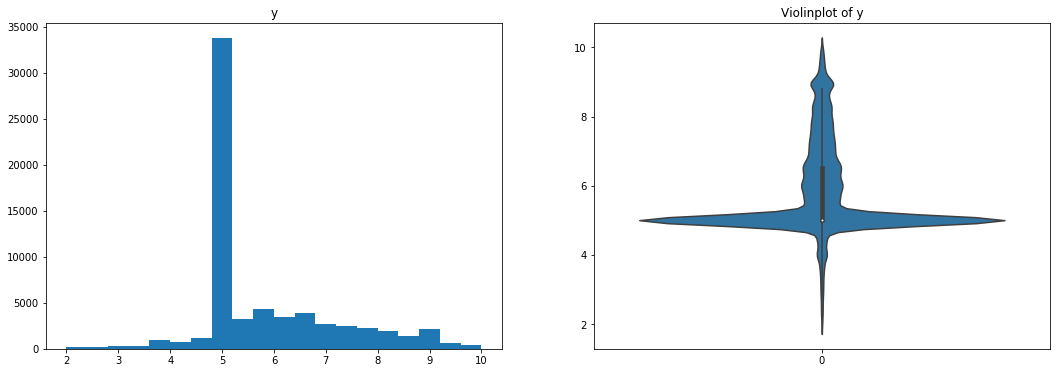

In [30]:
fig, ax = plt.subplots(figsize = (18, 6))
plt.subplot(1, 2, 1);
plt.hist(df['Label'], bins=20);
plt.title('y');
plt.subplot(1, 2, 2);
sns.violinplot(data=df['Label']);
plt.title('Violinplot of y');

In [ ]:
#----------------
#binary

In [ ]:
smiles, targets, y = process_BindingDB(path = 'BindingDB_All.tsv', df = None, y = 'Kd', binary = True, convert_to_log = False, threshold = 10)

In [ ]:
df_binary = pd.DataFrame(zip(smiles, targets, y))
df_binary.rename(columns={0:'SMILES',1: 'Target Sequence',2: 'Label'}, inplace=True)
print('in total: ' + str(len(df_binary)) + ' drug-target pairs')

In [ ]:
smiles = np.array(df_binary['SMILES'].values.tolist())
targets = np.array(df_binary['Target Sequence'].values.tolist())
y = np.array(df_binary['Label'].values.tolist())

In [ ]:
np.save("DB_smiles_binary.npy",smiles) 
np.save("DB_targets_binary.npy",targets)
np.save("DB_y_binary.npy",y)

In [ ]:
fig, ax = plt.subplots(figsize = (18, 6))
plt.subplot(1, 2, 1);
plt.hist(df_binary['Label'], bins=20);
plt.title('binary_y');
plt.subplot(1, 2, 2);
sns.violinplot(data=df_binary['Label']);
plt.title('Violinplot of binary_y');

In [ ]:
df_binary['Label'].value_counts()